Give it your best shot notebook

In [31]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
#from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, brier_score_loss, log_loss
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one
from ift6758.data.feature_engineering_pt2 import feature_engineering_two
import ift6758.data.advanced_models as adv
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from termcolor import colored
from feature_engine.selection import MRMR
import plotly as plt

<b> Data Handling: Downstream of all other tasks in this notebook </b>

In [32]:
df2 = feature_engineering_two(years = range(2016, 2022))
df2.head(10)
df2.columns

Index(['game_id', 'season', 'game_time', 'period', 'period_time', 'event_type',
       'team_id', 'team_name', 'coordinates_x', 'coordinates_y', 'shooter',
       'goalie', 'shot_type', 'empty_net', 'strength', 'situation_code',
       'previous_event_name', 'previous_event_x', 'previous_event_y',
       'previous_event_timeperiod', 'isHomeTeam', 'friendly_skaters',
       'opponent_skaters', 'zone_code', 'current_event_timeseconds',
       'previous_event_timeseconds', 'time_since_last_event', 'rebound',
       'distance_from_last_event', 'angle_shot_prev', 'angle_shot', 'speed',
       'angle_change', 'distance_shot', 'is_goal'],
      dtype='object')

In [33]:
X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
         'rebound','angle_change','speed']]
X = X.copy()
X['rebound'] = X['rebound'].astype(int)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns
median_values = X[numerical_cols].median()
X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')
X = adv._calculate_time_second(X)
X = adv._calculate_period_second(X)
X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
y = (df2['event_type'] == 'goal').astype(int)


In [34]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_val2[num_cols] = scaler.transform(X_val2[num_cols])
X_train2 = adv.change_to_one_hot(X_train2, ['shot_type', 'previous_event_name'])
X_val2 = adv.change_to_one_hot(X_val2, ['shot_type', 'previous_event_name'])
X_train2.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
272315,-0.054469,-0.924146,-1.590863,0.456229,-0.357455,0.164870,0.358393,1022,-1.073119,0.965474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59125,-0.054469,0.788808,0.316085,0.300175,-0.497876,0.164870,0.358393,183,-1.166651,1.583349,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150015,-0.054469,-1.238450,1.799266,0.088843,-0.358372,0.164870,0.358393,281,-1.073119,0.965474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294720,-1.195317,0.600226,-0.531447,0.958153,-0.376351,0.164870,0.358393,897,1.078120,-0.976417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416771,1.086378,-1.128444,-0.425506,-0.786816,-0.803377,0.164870,2.026367,963,0.314275,0.965474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67230,2.227226,1.071682,0.369056,-0.610775,0.003678,-4.093168,-2.977556,215,0.173977,-1.594292,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194517,-1.195317,-0.987007,0.422026,-0.344320,-0.794673,0.164870,0.358393,872,0.703992,-1.770827,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95602,-1.195317,-1.364171,-0.266593,-1.491640,-0.866396,0.164870,0.358393,374,-0.511926,0.303466,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
473396,1.086378,-0.845570,-0.054710,0.066451,-0.929894,0.164870,0.358393,833,-0.792522,-1.638426,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242248,-1.195317,-1.254165,-0.213623,-1.256910,-0.880447,0.164870,0.358393,512,-1.182239,-0.888149,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> Evaluation Model functions </b>

In [35]:
def evaluate_model_scores(name, y_true, y_pred, y_pred_proba):
    '''Evaluates each model based on the metrics set (AUC, F1 and ACC)'''
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(colored(f"\n{name}", "cyan", attrs=["bold"]))
    print(colored("-" * 60, "yellow"))
    print(colored(f"Validation AUC: {auc:.4f}", "green"))
    print(colored(f"Validation F1 : {f1:.4f}", "green"))
    print(colored(f"Validation Acc: {acc:.4f}", "green"))

def evaluate_model_scores_two(name, y_true, y_pred, y_pred_proba):
    '''Evaluates each model based on the metrics set (AUC, F1 and ACC)'''
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    brier_score_val= brier_score_loss(y_true, y_pred_proba)
    log_loss_acc = log_loss(y_true, y_pred)
    print(colored(f"\n{name}", "cyan", attrs=["bold"]))
    print(colored("-" * 60, "yellow"))
    print(colored(f"Validation AUC: {auc:.4f}", "green"))
    print(colored(f"Validation F1 : {f1:.4f}", "green"))
    print(colored(f"Validation Acc: {acc:.4f}", "green"))
    print(colored(f"Briars Acc: {brier_score_val:.4f}", "green"))
    print(colored(f"Log Loss Acc: {log_loss_acc:.4f}", "green"))

<b> Models Functions </b>

In [ ]:

results = {}

def run_models(X_train2, y_train2, X_val2, y_val2, added_metric=False, use_gridsearch=False, cv=3):
    best_overall_model = None
    best_overall_score = -float("inf")

    models = {
        "Ridge": CalibratedClassifierCV(RidgeClassifier(random_state=42), cv=5),
        "SGD": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', alpha=1e-4,
                             learning_rate_init=1e-3, max_iter=200, random_state=42),
    }

    param_grids = {
        "Ridge": {'model__estimator__alpha': [0.1, 1.0, 10.0]},
        "SGD": {'model__alpha': [1e-4, 1e-3, 1e-2]},
        "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
        "XGBoost": {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 7]},
        "CatBoost": {'model__depth': [4, 6, 8], 'model__learning_rate': [0.01, 0.1]},
        "MLP": {'model__hidden_layer_sizes': [(32,), (64, 32)], 'model__alpha': [1e-4, 1e-3]},
    }

    for name, model in models.items():
        print(f"\n{name}")
        pipe = Pipeline([('model', model)])
        if use_gridsearch:
            grid = param_grids.get(name, {})
            gs = GridSearchCV(
                estimator=pipe,
                param_grid=grid,
                scoring="accuracy",
                cv=cv,
                n_jobs=-1,
                refit=True,
                verbose=0,
            )
            try:
                gs.fit(X_train2, y_train2)
                y_pred = gs.predict(X_val2)
                print(f"Best CV score: {gs.best_score_:.4f}")
                print(f"Best Params: {gs.best_params_}")
                best_model = gs.best_estimator_
            except Exception as e:
                print(f"Skipped {name} — error: {e}")
                continue
        else:
            try:
                pipe.fit(X_train2, y_train2)
                best_model = pipe
            except Exception as e:
                print(f"Skipped {name} — error: {e}")
                continue

        try:
            y_pred_proba = best_model.predict_proba(X_val2)[:, 1]
            y_pred = (y_pred_proba > 0.5).astype(int)
            if added_metric:
                evaluate_model_scores_two(name, y_val2, y_pred, y_pred_proba)
            else:
                evaluate_model_scores(name, y_val2, y_pred, y_pred_proba)
                
            acc = accuracy_score(y_val2, y_pred)
            roc_auc = roc_auc_score(y_val2, y_pred_proba)

            print(f"Validation Accuracy: {acc:.4f}")
            print(f"Validation ROC AUC: {roc_auc:.4f}")

            results[name] = {
                "model": best_model,
                "accuracy": acc,
                "roc_auc": roc_auc,
                "cv_best_score": getattr(gs, "best_score_", None) if use_gridsearch else None,
                "best_params": getattr(gs, "best_params_", None) if use_gridsearch else None,
            }
            
            if roc_auc > best_overall_score:
                best_overall_score = roc_auc
                best_overall_model = best_model
                
        except Exception as e:
            print(f"Skipped {name} — error: {e}")
        
        return best_overall_model

<b> Plots </b>

In [37]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model", figsize=(6, 5)):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

<h1> Testing with several models </h1>

In [38]:
gr_best_model, gr_X_val, gr_y_val = run_models(X_train2, y_train2, X_val2, y_val2, added_metric=True, use_gridsearch=True), X_val2, y_val2


Ridge
Best CV score: 0.9032
Best Params: {'model__estimator__alpha': 0.1}

Ridge
------------------------------------------------------------
Validation AUC: 0.7257
Validation F1 : 0.0272
Validation Acc: 0.9034
Briars Acc: 0.0819
Log Loss Acc: 3.4801
Validation Accuracy: 0.9034
Validation ROC AUC: 0.7257


<h1> Feature Relevance and Selection Experiments </h1>

<b> Training a Random Forest and seing feature relevance and retraining </b> 

In [39]:
import matplotlib.pyplot as plt
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train2, y_train2)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


distance_shot                        0.083359
game_time_seconds                    0.075412
speed                                0.072589
distance_from_last_event             0.068988
angle_shot                           0.066072
period_time_seconds                  0.064164
previous_event_timeseconds           0.062083
previous_event_timeperiod_seconds    0.061873
time_since_last_event                0.056967
previous_event_x                     0.055145
dtype: float64


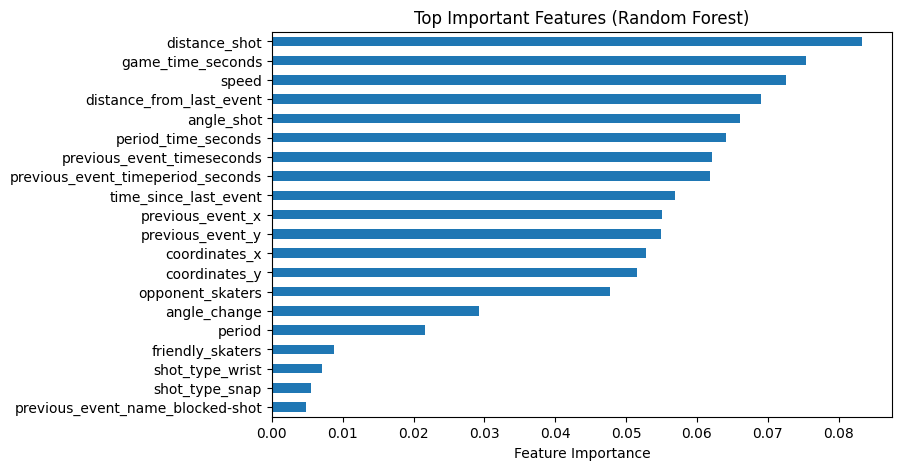

In [40]:
importances = pd.Series(rf.feature_importances_, index=X_train2.columns)
importances = importances.sort_values(ascending=False)
print(importances.head(10))
plt.figure(figsize=(8, 5))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Important Features (Random Forest)")
plt.show()


<b> <u> Computing MRMR and retraining</u> </b>

In [41]:
selection = MRMR(method="FCQ", regression=False, max_features=20)
selection.fit(X_train2, y_train2)

,variables,None
,method,'FCQ'
,max_features,20
,discrete_features,'auto'
,n_neighbors,3
,scoring,'roc_auc'
,cv,3
,param_grid,None
,regression,False
,confirm_variables,False
,random_state,None


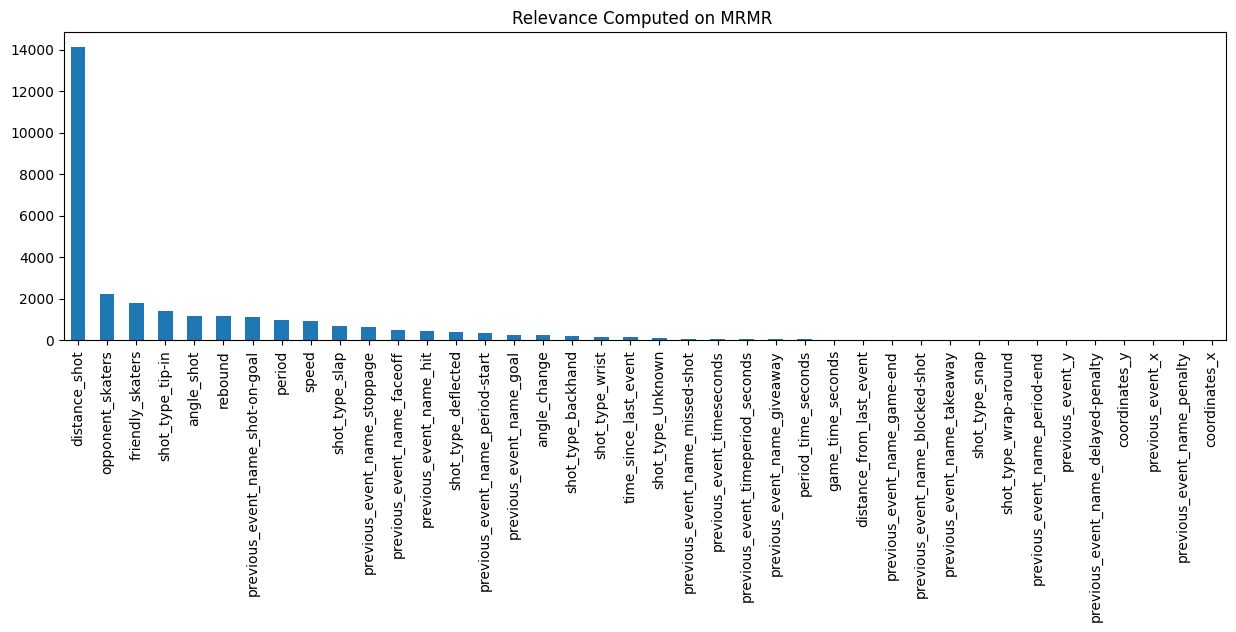

In [42]:
pd.Series(selection.relevance_, index=selection.variables_).sort_values(ascending=False).plot.bar(figsize=(15, 4))
plt.title("Relevance Computed on MRMR ")
plt.show()


In [43]:
np.sum ( selection.get_support())

20

In [44]:
mask = selection.get_support() #Takes the first 20 relevant features to calculate the AUC 
selected_features = X_train2.columns[mask]
X_train2_t20 = X_train2[selected_features]
X_val2_t20 = X_val2[selected_features]

In [45]:
mrmr_model, mrmr_X_val, mrmr_y_val = run_models(X_train2_t20, y_train2, X_val2_t20, y_val2), X_val2_t20, y_val2


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7156
Validation F1 : 0.0308
Validation Acc: 0.9031
Validation Accuracy: 0.9031
Validation ROC AUC: 0.7156


<b> <u> Computing LASSO and retraining  </u> </b>

In [46]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.001, random_state=42)
lasso.fit(X_train2, y_train2)
importance = pd.Series(lasso.coef_, index=X_train2.columns)
importance = importance.reindex(importance.abs().sort_values(ascending=False).index)
print(importance)

distance_shot                         -0.053056
previous_event_name_stoppage          -0.033575
angle_shot                            -0.027050
coordinates_x                          0.016805
speed                                  0.015851
shot_type_backhand                    -0.013731
period                                 0.008226
rebound                                0.008177
friendly_skaters                      -0.007892
previous_event_name_hit               -0.007728
opponent_skaters                      -0.007666
shot_type_wrist                       -0.007364
distance_from_last_event              -0.005577
angle_change                           0.002584
previous_event_y                       0.000249
previous_event_name_faceoff           -0.000241
coordinates_y                          0.000095
time_since_last_event                  0.000032
previous_event_timeseconds             0.000021
previous_event_name_shot-on-goal       0.000000
previous_event_name_period-start       0

In [47]:
top_features = importance.abs().nlargest(20).index
X_train2_t20_lasso = X_train2[top_features]
X_val2_t20_lasso = X_val2[top_features]

In [48]:
lasso_model, lasso_X_val, lasso_y_val = run_models(X_train2_t20_lasso, y_train2, X_val2_t20_lasso, y_val2), X_val2_t20_lasso, y_val2


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7222
Validation F1 : 0.0294
Validation Acc: 0.9034
Validation Accuracy: 0.9034
Validation ROC AUC: 0.7222


Filtering by features such as MRMR and  Lasso does not beat when we add all features

<h1> Testing with different kinds of splits </h1>

<b> Removing the first 20 games of the season </b>

<p>Sidenote: created a new feature as well called IsRush </p>

In [49]:

new_df  = df2.copy()
new_df = new_df.sort_values(["team_name", "game_time"])
new_df["game_number"] = new_df.groupby("team_name")["game_id"].cumcount() + 1
new_df = new_df[new_df["game_number"] > 20]



In [50]:
X_omit = new_df[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
         'rebound','angle_change','speed']]
X_omit['rebound'] = X_omit['rebound'].astype(int)
X_omit['isRush'] = (X_omit['time_since_last_event'] < 4 ).astype(int)
categorical_cols = X_omit.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_omit.select_dtypes(include=['number']).columns
median_values = X_omit[numerical_cols].median()
X_omit.loc[:, numerical_cols] = X_omit[numerical_cols].fillna(median_values)
X_omit.loc[:, categorical_cols] = X_omit[categorical_cols].fillna('Unknown')
X_omit = adv._calculate_time_second(X_omit)
X_omit = adv._calculate_period_second(X_omit)
X_omit = X_omit.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
y_omit = (new_df['event_type'] == 'goal').astype(int)


In [51]:

X_train_split1, X_val_split1, y_train_split1, y_val_split1 = train_test_split(
    X_omit, y_omit, test_size=0.2, random_state=42, stratify=y_omit
)
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train_split1.columns
    if col not in exclude_cols and X_train_split1[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train_split1[num_cols] = scaler.fit_transform(X_train_split1[num_cols])
X_val_split1[num_cols] = scaler.transform(X_val_split1[num_cols])
X_train_split1 = adv.change_to_one_hot(X_train_split1, ['shot_type', 'previous_event_name'])
X_val_split1 = adv.change_to_one_hot(X_val_split1, ['shot_type', 'previous_event_name'])
X_train_split1.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
399246,-0.054533,-0.843490,1.269787,0.458253,-0.456016,0.165172,0.358209,865,-1.072376,0.966856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119721,-0.054533,0.774413,-1.063461,0.578274,0.426970,0.165172,0.358209,939,0.439941,-0.048270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
265963,1.086360,1.119985,-0.055922,-0.824944,-0.784974,0.165172,-1.310077,955,1.079169,-0.975123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
279358,-0.054533,-0.702120,-1.222546,0.837295,-0.445021,0.165172,-1.310077,110,-1.041195,0.348954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335792,-0.054533,1.135692,-0.215007,-0.854567,-0.263577,0.165172,-1.310077,777,0.876487,-1.725434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
198313,1.086360,0.177517,-1.275574,2.517358,-0.063417,0.165172,0.358209,785,-0.308422,0.966856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29050,1.086360,1.104277,0.315277,-0.725218,-0.041503,0.165172,0.358209,360,1.453350,-0.666172,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258691,-0.054533,-1.031983,-1.222546,-0.062759,-0.512346,-1.967328,-1.310077,131,1.141532,1.540623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83768,1.086360,1.339894,0.262248,-1.436023,1.710948,0.165172,-1.310077,1026,0.003396,-0.004134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
120987,-1.195426,0.491673,1.216759,1.507277,0.171256,0.165172,0.358209,947,1.079169,0.966856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
rm_20_model, rm_20_X_val, rm_20_y_val = run_models(X_train_split1, y_train_split1, X_val_split1, y_val_split1), X_val_split1, y_val_split1


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7328
Validation F1 : 0.0344
Validation Acc: 0.9035
Validation Accuracy: 0.9035
Validation ROC AUC: 0.7328


In [53]:
_ = run_models(X_train_split1, y_train_split1, X_val_split1, y_val_split1 ,True)


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7328
Validation F1 : 0.0344
Validation Acc: 0.9035
Briars Acc: 0.0813
Log Loss Acc: 3.4780
Validation Accuracy: 0.9035
Validation ROC AUC: 0.7328


In [54]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_split1, y_train_split1)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


distance_shot                        0.083359
game_time_seconds                    0.075412
speed                                0.072589
distance_from_last_event             0.068988
angle_shot                           0.066072
period_time_seconds                  0.064164
previous_event_timeseconds           0.062083
previous_event_timeperiod_seconds    0.061873
time_since_last_event                0.056967
previous_event_x                     0.055145
dtype: float64


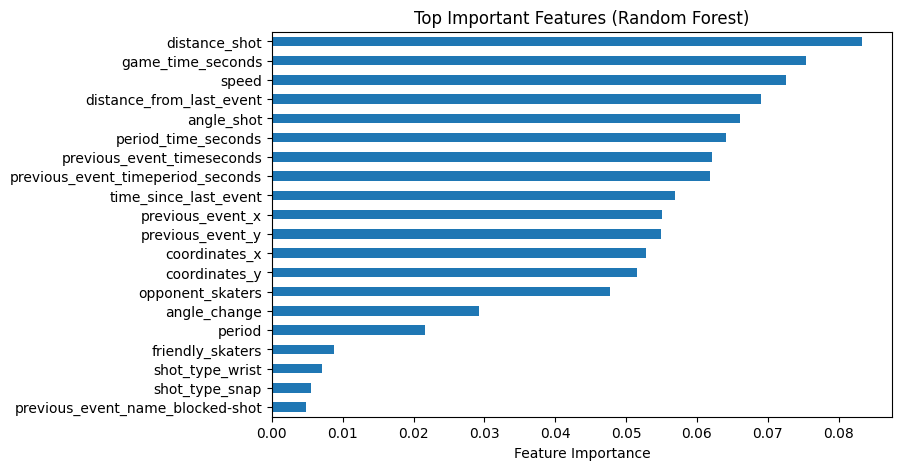

In [55]:
importance =  pd.Series(rf.feature_importances_, index=X_train_split1.columns)
importance = importance.sort_values(ascending=False)
print(importances.head(10))
plt.figure(figsize=(8, 5))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Important Features (Random Forest)")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def _get_scores(model, X):
    """
    Returns continuous scores for a model on X.
    - Uses predict_proba if available
    - Falls back to decision_function if not
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model doesn't have predict_proba function.")


def plot_all_curves(models, X_val_dict, y_val_dict, n_bins=20):
    """
    models: dict[str, fitted model]
    X_val_dict: dict[str, X_val for that model]
    y_val_dict: dict[str, y_val for that model]

    For each model:
      - ROC curve + AUC
      - Goal Rate vs Probability Percentile
      - Cumulative Goals vs Shots
      - Reliability curve

    All models are overlaid on the same 4 plots,
    but each uses its own validation set.
    """

    model_data = {}
    model_aucs = {}
    for name, model in models.items():
        if name not in X_val_dict or name not in y_val_dict:
            print(f"Warning: missing X_val or y_val for {name}, skipping.")
            continue

        X_val = X_val_dict[name]
        y_val = y_val_dict[name]

        y_score = _get_scores(model, X_val)
        auc = roc_auc_score(y_val, y_score)

        model_data[name] = {
            "y_true": np.asarray(y_val),
            "y_score": np.asarray(y_score),
        }
        model_aucs[name] = auc

    # 1. ROC CURVE + AUC
    plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = model_aucs[name]
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — XGBoost (Distance + Angle)")
    plt.legend()
    plt.show()

    # 2. Goal Rate vs Probability Percentile 
    plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        df_val = pd.DataFrame({"y_true": y_true, "y_pred": y_score})
        df_val["percentile"] = pd.qcut(
            df_val["y_pred"],
            n_bins,
            labels=False,
            duplicates="drop",
        )

        goal_rate = df_val.groupby("percentile")["y_true"].mean()
        plt.plot(
            goal_rate.index,
            goal_rate.values,
            marker="o",
            label=f"{name} (AUC={model_aucs[name]:.3f})",
        )

    plt.xlabel("Predicted Probability Percentile (0=Low, 19=High)")
    plt.ylabel("Actual Goal Rate")
    plt.title("Goal Rate vs Probability Percentile — XGBoost")
    plt.show()

    # 3. Cumulative Goals vs Shots
    plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        df_val = pd.DataFrame({"y_true": y_true, "y_pred": y_score})
        df_sorted = df_val.sort_values("y_pred", ascending=False)

        df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
        df_sorted["cum_goals_prop"] = (
            df_sorted["cum_goals"] / df_sorted["y_true"].sum()
        )
        df_sorted["cum_shots_prop"] = (
            np.arange(1, len(df_sorted) + 1) / len(df_sorted)
        )

        plt.plot(
            df_sorted["cum_shots_prop"],
            df_sorted["cum_goals_prop"],
            label=f"{name} (AUC={model_aucs[name]:.3f})",
        )

    plt.xlabel("Cumulative Proportion of Shots")
    plt.ylabel("Cumulative Proportion of Goals")
    plt.title("Cumulative Goals vs Shots — XGBoost")
    plt.show()

    # 4. Reliability (Calibration) Curve
    plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        prob_true, prob_pred = calibration_curve(
            y_true, y_score, n_bins=n_bins, strategy="quantile"
        )

        plt.plot(
            prob_pred,
            prob_true,
            marker="o",
            label=f"{name} (AUC={model_aucs[name]:.3f})",
        )

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Goal Frequency")
    plt.title("Reliability Curve — XGBoost")
    plt.legend()
    plt.show()


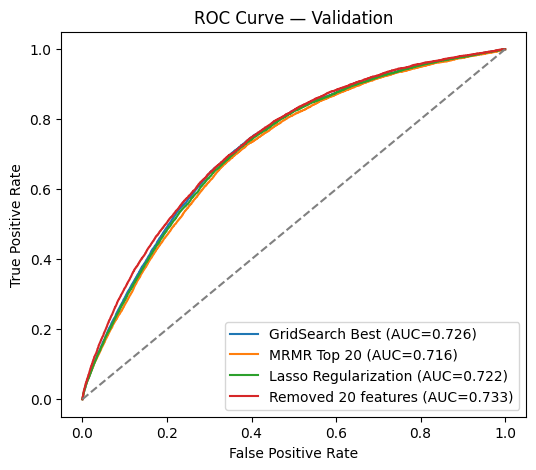

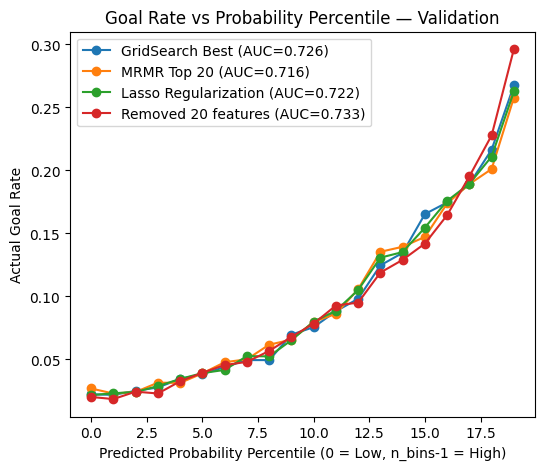

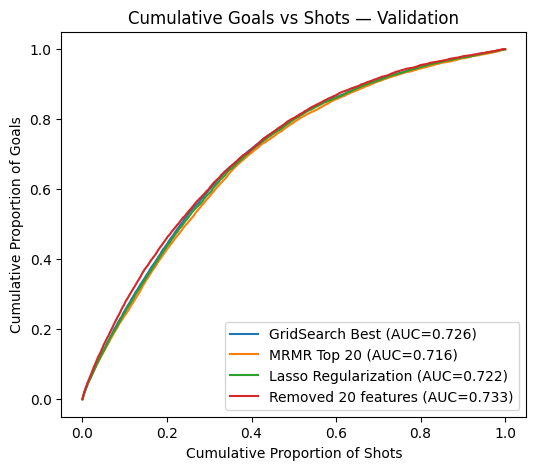

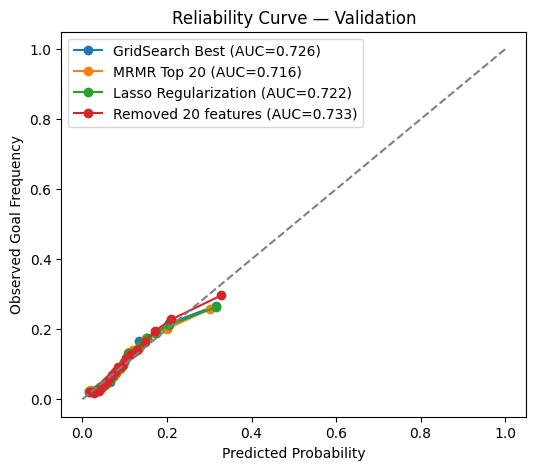

In [60]:
models = {
    "GridSearch Best": gr_best_model,
    "MRMR Top 20": mrmr_model,
    "Lasso Regularization": lasso_model,
    "Removed 20 features": rm_20_model
}

X_val = {
    "GridSearch Best": gr_X_val,
    "MRMR Top 20": mrmr_X_val,
    "Lasso Regularization": lasso_X_val,
    "Removed 20 features": rm_20_X_val
}

y_val = {
    "GridSearch Best": gr_y_val,
    "MRMR Top 20": mrmr_y_val,
    "Lasso Regularization": lasso_y_val,
    "Removed 20 features": rm_20_y_val
}


plot_all_curves(models, X_val, y_val)